<a href="https://colab.research.google.com/github/matiasvallejosdev/my-face-recognition/blob/main/face_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Face Classification

## 1. Packages


In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as tk
import numpy as np
import pandas as pd

import pathlib
import imageio

import matplotlib.pyplot as plt
import os

tf.__version__

'2.5.0'

## 2. Load and split the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Preprocessing
batch_size = 32
data_root = ("/content/drive/My Drive/Machine Learning/Datasets/my-face/")

IMAGE_SHAPE = (30, 30) # (height, width) in no. of pixels
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

print(TRAINING_DATA_DIR)

/content/drive/My Drive/Machine Learning/Datasets/my-face/


In [98]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAINING_DATA_DIR,
  validation_split=0.2,
  seed = 4,
  subset="training",
  shuffle=True)

print('')

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAINING_DATA_DIR,
  validation_split=0.2,
  seed = 4,
  subset="validation",
  shuffle=True)

Found 1755 files belonging to 2 classes.
Using 1404 files for training.

Found 1755 files belonging to 2 classes.
Using 351 files for validation.


In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [228]:
# Define generators
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Define generators datasets
train_generator = train_datagen.flow_from_directory(
    directory=TRAINING_DATA_DIR,
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=4
)
valid_generator = train_datagen.flow_from_directory(
    directory=TRAINING_DATA_DIR,
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=4
)

Found 1405 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [226]:
class_names = train_generator.classes
print("Total classes: {}".format(train_generator.num_classes))
print("Total: {}".format(str(len(class_names))))

Total classes: 2
Total: 1405


In [197]:
model = tf.keras.Sequential([
            tfl.Conv2D(16, 3, padding='same', activation='relu',input_shape=(32,32,3)),
            tfl.MaxPooling2D(),
            tfl.Conv2D(32, 3, padding='same', activation='relu'),
            tfl.MaxPooling2D(),
            tfl.Conv2D(64, 3, padding='same', activation='relu'),
            tfl.MaxPooling2D(),
            tfl.Flatten(),
            tfl.Dense(128, activation='relu'),
            tfl.Dense(2, activation='sigmoid')
])

In [198]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)            

In [199]:
history = model.fit_generator(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
175/175 [==============================] - 8s 39ms/step - loss: 0.4540 - accuracy: 0.8346 - val_loss: 0.3750 - val_accuracy: 0.8576
Epoch 2/10
175/175 [==============================] - 7s 38ms/step - loss: 0.2953 - accuracy: 0.8855 - val_loss: 0.1480 - val_accuracy: 0.9419
Epoch 3/10
175/175 [==============================] - 7s 38ms/step - loss: 0.1798 - accuracy: 0.9248 - val_loss: 0.1217 - val_accuracy: 0.9564
Epoch 4/10
175/175 [==============================] - 7s 39ms/step - loss: 0.1098 - accuracy: 0.9628 - val_loss: 0.1040 - val_accuracy: 0.9622
Epoch 5/10
175/175 [==============================] - 7s 39ms/step - loss: 0.0974 - accuracy: 0.9649 - val_loss: 0.1122 - val_accuracy: 0.9593
Epoch 6/10
175/175 [==============================] - 7s 39ms/step - loss: 0.0717 - accuracy: 0.9785 - val_loss: 0.0576 - val_accuracy: 0.9797
Epoch 7/10
175/175 [==============================] - 7s 40ms/step - loss: 0.0917 - accuracy: 0.9678 - val_loss: 0.0447 - val_accuracy: 0.9913

In [203]:
test_loss, test_accuracy = model.evaluate_generator(valid_generator)
predictions = model.predict(valid_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [204]:
print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_accuracy))

Test loss: 0.09906724095344543
Test accuracy: 0.9628571271896362


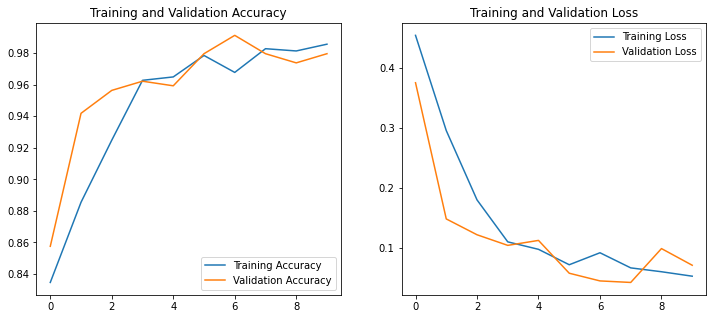

In [205]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()